In [1]:
import os
import glob
import itertools
import string
from os import path
from collections import defaultdict
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import textract
from sklearn.feature_extraction.text import TfidfVectorizer
import stylecloud

import spacy
from spacy import displacy

In [2]:
%load_ext autoreload
%autoreload 2

from whitelist import whitelist

# Utils

In [2]:
def freq_dist_to_csv(fd, name):
    df = pd.DataFrame(fd.most_common())
    df.columns = ["word", "freq"]
    df.to_csv(path.join("processed", name + ".csv"))

In [3]:
stop_words = set()
stop_words = stop_words.union(set(stopwords.words('english')))
stop_words = stop_words.union(set(string.punctuation))
stop_words = stop_words.union({
    "purdue",
    "@",
    "et",
    "al",
    "j",
    "patient",
    "patients",
    "n",
    "england",
    "journal",
    "download",
    "downloaded",
    "university",
    "copyright",
    "use",
    "medical",
    "data",
    "however",
    "mers-cov",
    "..",
    "health",
    "april", 
    "study",
    "⫾"
})

digits_re = re.compile(r"\w?\d+\w?")

lemmatizer = nltk.stem.WordNetLemmatizer()

def get_tokens_from_text(text):
    tokens = []
    
    iterator = nltk.tokenize.word_tokenize(text)
    iterator = map(lambda x: x.lower(), iterator)
    iterator = filter(lambda x: x not in stop_words and not digits_re.fullmatch(x), iterator)
#     iterator = filter(lambda x: x in whitelist, iterator)
    
    for token in iterator:
        tokens.append(token)
            
    return tokens

def get_bigrams_from_text(text):
    tokens = []
    
    iterator = nltk.tokenize.word_tokenize(text)
    iterator = map(lambda x: x.lower(), iterator)
#     iterator = map(lambda x: lemmatizer.lemmatize(x), iterator)
    iterator = nltk.bigrams(iterator)
#     iterator = filter(lambda x: x[0] in {"lower", "upper", "higher", "increase", "decrease"}, iterator)
    
    for token in iterator:
#         if all(map(lambda x: x not in stop_words and not digits_re.fullmatch(x), token)):
        if any(map(lambda x: x in whitelist, token)):
            tokens.append(" ".join(token))
            
    return tokens

In [131]:
def save_text_file(text, name):
    with open(path.join("text", name + ".txt"), "w") as f:
        f.write(text)

# Processing

In [11]:
# not used
pdfs = glob.glob('./papers/*/*')

for pdf in pdfs:
    category = pdf.split("/")[2]
    paper_name = pdf.split("/")[3]
    text = textract.process(pdf).decode("utf-8").lower()
    save_text_file(text, f"{category}-{paper_name}")

In [4]:
pdfs = glob.glob('./papers/*/*')
pdfs_text = {}
for pdf in pdfs:
    category = pdf.split("/")[2]
    paper_name = pdf.split("/")[3]
    pdfs_text[(category, paper_name)] = textract.process(pdf).decode("utf-8").lower()

In [5]:
tokens_by_category = defaultdict(list)

for key in pdfs_text:
    category, _ = key
    text = pdfs_text[key]
    tokens_by_category[category] += get_tokens_from_text(text)
#     tokens_by_category[category] += get_bigrams_from_text(text)


frequencies_by_category = {}
for category in tokens_by_category:
    frequencies_by_category[category] = nltk.FreqDist(tokens_by_category[category])

In [257]:
for category in frequencies_by_category:
    freq_dist_to_csv(frequencies_by_category[category], category)

# Plots

In [260]:
fd = frequencies_by_category["vaping"]

In [261]:
fd

FreqDist({('upper', 'respiratory'): 2, ('lower', 'toxicity'): 1, ('lower', 'cinnamaldehyde'): 1, ('higher', 'concentrations'): 1, ('lower', 'concentrations'): 1, ('lower', 'levels'): 1, ('lower', 'lobes'): 1, ('lower', 'respiratory'): 1, ('upper', 'limit'): 1, ('lower', 'lungs'): 1})

In [224]:
dir(fd)

['B',
 'N',
 'Nr',
 '_N',
 '__add__',
 '__and__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__isub__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__missing__',
 '__module__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_cumulative_frequencies',
 '_keep_positive',
 'clear',
 'copy',
 'elements',
 'freq',
 'fromkeys',
 'get',
 'hapaxes',
 'items',
 'keys',
 'max',
 'most_common',
 'pformat',
 'plot',
 'pop',
 'popitem',
 'pprint',
 'r_Nr',
 'setdefault',
 'subtract',
 'tabulate',
 'unicode_repr',
 'update',
 'values']

In [7]:
total_df = None

for category in frequencies_by_category:
    freqs = frequencies_by_category[category].most_common()
    df = pd.DataFrame(freqs)
    df.columns = ['word', category]
#     df[category] /= df[category].sum()
    
    if isinstance(total_df, type(None)):
        total_df = df
    else:
        total_df = pd.merge(total_df, df, on="word", how="outer").fillna(0, downcast='infer')
        
total_df['sum'] = total_df['vaping'] + total_df['ards'] + total_df['mers']
total_df = total_df.sort_values(by="sum", ascending=False)

In [390]:
total_df.ards.sum() + total_df.vaping.sum() + total_df.mers.sum()

118849

In [402]:
total_df[total_df.word == "thc"]

,word,vaping,ards,mers,sum
193,thc,19,0,0,19


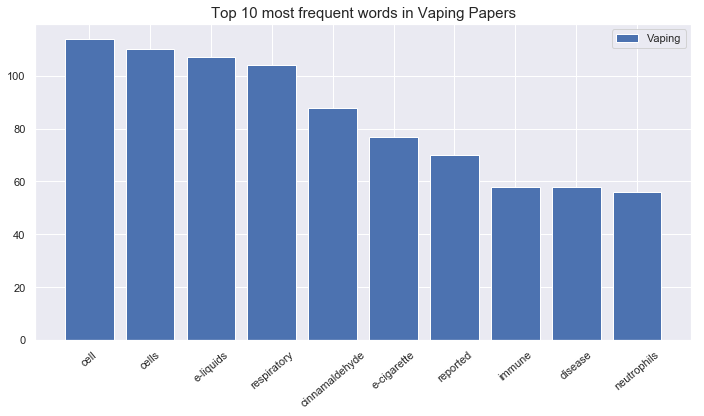

In [16]:
total_df = total_df.sort_values(by="vaping", ascending=False)

df = total_df[:10]
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xticklabels(df.word, rotation=40)
ax.set_title("Top 10 most frequent words in Vaping Papers", 
             fontdict={"fontsize": 15, "fontweight": 2})
plt.bar(df.word, df.vaping, label="Vaping")
ax.legend()
plt.savefig('../images/vaping_top_10.png', dpi=400)
plt.tight_layout(pad=4)

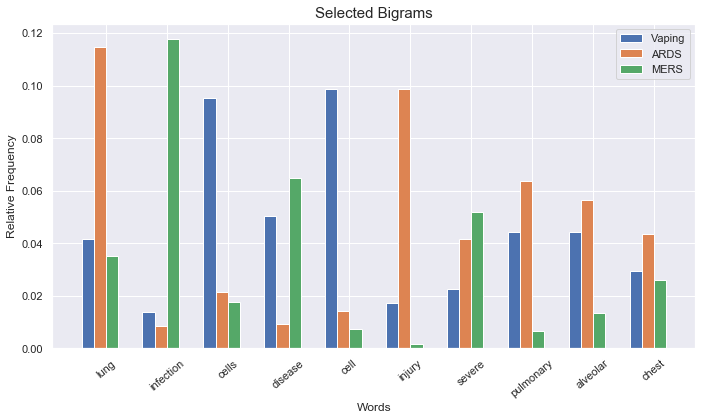

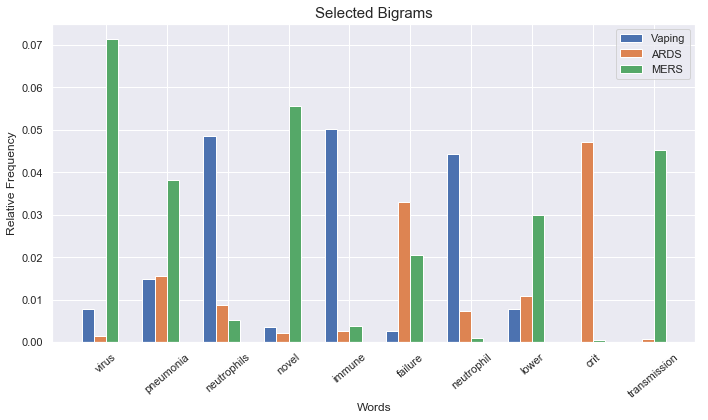

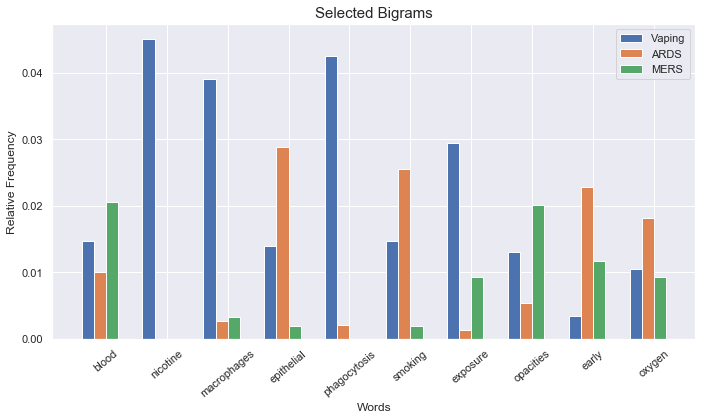

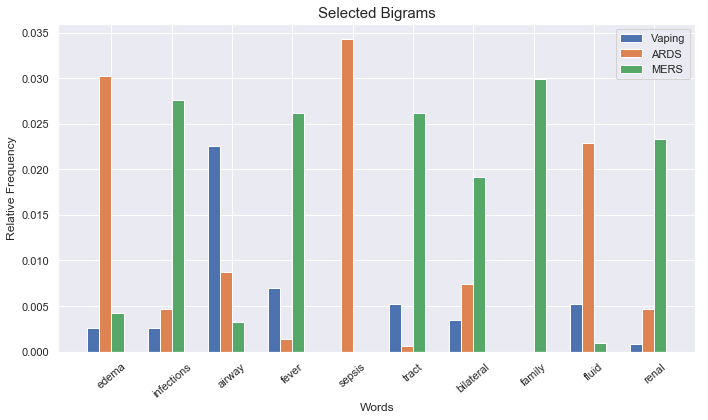

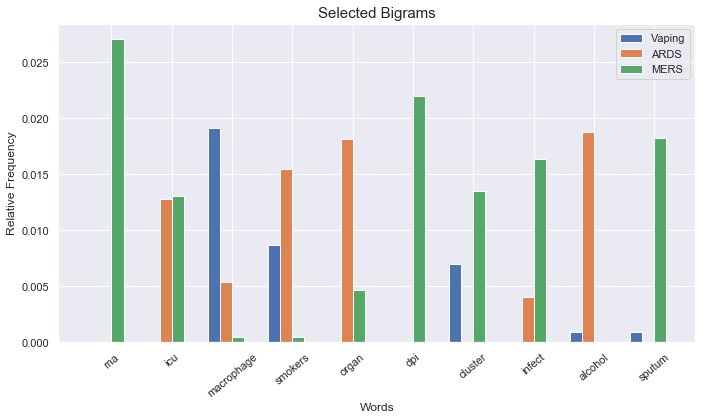

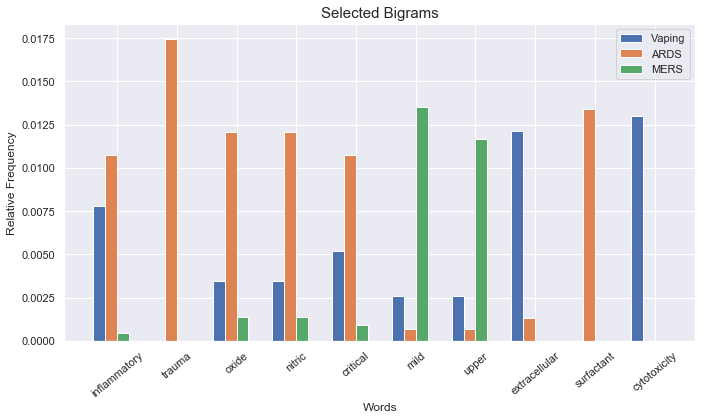

In [374]:
def plot_bars(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.20
    ind = np.arange(df.shape[0])
    
    plt.bar(ind - width, df.vaping, width, label="Vaping")
    plt.bar(ind, df.ards, width, label="ARDS")
    plt.bar(ind + width, df.mers, width, label="MERS")
    
    ax.set_xticks(ind + width / 2)
    
    ax.set_xticklabels(df.word, rotation=40)
#     labels = ax.set_xticklabels(df.word)
#     for i, label in enumerate(labels):
#         label.set_y(label.get_position()[1] - (i % 2) * 0.075)

    
    ax.autoscale_view()
    ax.legend()
    ax.set_title("Selected Bigrams", fontdict={"fontsize": 15, "fontweight": 2})
    ax.set_ylabel("Relative Frequency")
    ax.set_xlabel("Words")
    plt.tight_layout()



# for i in range(6):
#     plot_bars(total_df[i * 10:(i+1) * 10])
#     plt.savefig(f'plots/selected_words_{i}.png', dpi=400)

In [376]:
nltk.tokenize.word_tokenize("E-cigarettes are battery-operated devices")

['E-cigarettes', 'are', 'battery-operated', 'devices']

In [382]:
i = 0
for word in whitelist:
    print(word, end="\t")
    i += 1
    if i == 5:
        i = 0
        print()

smokers	alcohol	virus	inflammatory	disease	
surfactant	nicotine	alveolar	cytotoxicity	severe	
transmission	sepsis	extracellular	lower	injury	
exposure	edema	icu	oxygen	phagocytosis	
cluster	macrophages	cells	organ	crit	
opacities	mild	upper	neutrophils	infections	
smoking	neutrophil	fever	pneumonia	nitric	
family	trauma	critical	rna	opacity	
immune	sputum	infect	epithelial	bilateral	
novel	early	renal	macrophage	oxide	
infection	chest	bmi	tract	blood	
airway	failure	pulmonary	dpi	fluid	
lung	cell	

In [380]:
pd.DataFrame(whitelist)

,0
0,smokers
1,alcohol
2,virus
3,inflammatory
4,disease
5,surfactant
6,nicotine
7,alveolar
8,cytotoxicity
9,severe


# Spacy Stuff

In [5]:
nlp = spacy.load("en_core_web_md")
doc = nlp(pdfs_text[('vaping', '2012_0.pdf')])

In [15]:
get_tokens_from_text(pdfs_text[('vaping', '2012_0.pdf')])

['chest',
 'electronic',
 'cigarettes',
 'thing',
 'free',
 'lunch…or',
 'puff',
 'pulmonary',
 'cardiac',
 'mediascine',
 'practitioners',
 'many',
 'us',
 'doubt',
 'asked',
 'patients',
 'smoke',
 'so-called',
 '“',
 'electronic',
 'cigarettes',
 '”',
 'e-cigarettes',
 'devices',
 'termed',
 'electronic',
 'nicotine',
 'delivery',
 'systems',
 'ends',
 'world',
 'health',
 'organization',
 'available',
 'us',
 'market',
 'since',
 '2007.',
 'patients',
 'likely',
 'heard',
 'far',
 'devices',
 'marketing',
 'chat',
 'rooms',
 'word',
 'mouth',
 'physicians',
 'medical',
 'literature',
 'ends',
 'currently',
 'regulated',
 'us',
 'food',
 'drug',
 'administration',
 'fda',
 'medical',
 'devices—',
 'recent',
 'court',
 'decisions',
 'denied',
 'agency',
 'right',
 'oversight—manufacturers',
 'ends',
 'required',
 'establish',
 'either',
 'safety',
 'efﬁ',
 'ﬁcacy',
 'data',
 'answer',
 'patients',
 '’',
 'queries',
 'products',
 'e-cigarettes',
 'smoking',
 'cessation',
 'tool',
 'ha

In [8]:
displacy.render(doc, style="ent")

# Other

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(pdfs_text.values())

In [ ]:
x = X.toarray()

In [ ]:
features = np.array(vectorizer.get_feature_names())

In [ ]:
stop_words = set()
# stop_words = set(features[x.max(axis = 0) < 0.1])
stop_words = stop_words.union(set(stopwords.words('english')))
stop_words = stop_words.union(set(string.punctuation))
stop_words = stop_words.union({str(x) for x in range(100)})

In [ ]:
tokens = []

for text in pdfs_text.values():
    for token in nltk.tokenize.word_tokenize(text):
        if token not in stop_words:
            tokens.append(token)

fd = nltk.FreqDist(tokens)

In [ ]:
# fd.most_common()

for word, freq in fd.most_common()[:5]:
    plt.bar(word, freq)

In [396]:
pdf

'./papers/mers/2013_5.pdf'

In [395]:
stylecloud.gen_stylecloud(pdf, icon_name="fas fa-smoking")

In [392]:
?stylecloud.gen_stylecloud

Signature:
stylecloud.gen_stylecloud(
    text=None,
    file_path=None,
    size=512,
    icon_name='fas fa-flag',
    palette='cartocolors.qualitative.Bold_5',
    colors=None,
    background_color='white',
    max_font_size=200,
    max_words=2000,
    stopwords=True,
    custom_stopwords={'with', 'k', 'having', 'these', 'am', 'r', 'had', 'the', "shan't", "you've", 'yourselves', 'himself', "you'd", "wouldn't", "we're", 'this', "don't", 'get', 'to', "he'll", 'other', 'was', 'yours', 'too', 'http', 'our', 'through', "they're", 'can', 'doing', "they'd", 'it', 'you', 'under', 'as', 'those', 'just', 'like', 'theirs', 'are', 'such', 'any', 'same', "wasn't", 'during', "we'd", 'about', "i've", "you're", "they've", 'against', 'all', 'be', 'what', "why's", 'nor', 'is', 'when', 'however', 'so', 'a', 'since', 'but', 'an', 'itself', "she's", 'www', 'into', "it's", 'then', "weren't", "how's", 'ought', 'few', "let's", "couldn't", 'by', 'at', 'do', 'where', 'more', 'off', 'otherwise', 'were', 'she'